Testing the preprocessing of vorticity and eke tendency.

This will be implemented into preprocess_data.py

In [134]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [135]:
directory = "/gws/nopw/j04/ai4pex/twilder/NEMO_data/DINO/EXP16/features/SO_JET/coarsened_data/"
filename = "MINT_1d_0061-0072_eke_tendency_c_SO_JET.nc"
ds = xr.open_dataset(directory + filename)
ds

<xarray.Dataset> Size: 112MB
Dimensions:       (t: 4319, y_c: 54, x_c: 60)
Coordinates:
  * t             (t) object 35kB 0061-01-03 00:00:00 ... 0073-01-01 00:00:00
    gphit         (y_c, x_c) float64 26kB ...
    glamt         (y_c, x_c) float64 26kB ...
Dimensions without coordinates: y_c, x_c
Data variables:
    eke_tendency  (t, y_c, x_c) float64 112MB ...

In [137]:
ds = ds.isel(t=0)
ds

<xarray.Dataset> Size: 78kB
Dimensions:       (y_c: 54, x_c: 60)
Coordinates:
    t             object 8B 0061-01-03 00:00:00
    gphit         (y_c, x_c) float64 26kB ...
    glamt         (y_c, x_c) float64 26kB ...
Dimensions without coordinates: y_c, x_c
Data variables:
    eke_tendency  (y_c, x_c) float64 26kB 2.601e-08 5.883e-09 ... 2.144e-08

Distribution prior to transformation

In [5]:
df = ds.to_dataframe()
df

t      gphit   glamt  eke_tendency
y_c x_c                                                      
0   0    0061-01-03 00:00:00 -47.422141   2.625  2.601189e-08
    1    0061-01-03 00:00:00 -47.422141   2.875  5.882740e-09
    2    0061-01-03 00:00:00 -47.422141   3.125  1.753329e-09
    3    0061-01-03 00:00:00 -47.422141   3.375 -1.259990e-09
    4    0061-01-03 00:00:00 -47.422141   3.625 -3.144903e-09
...                      ...        ...     ...           ...
53  55   0061-01-03 00:00:00 -37.693867  16.375  4.181912e-09
    56   0061-01-03 00:00:00 -37.693867  16.625  2.616794e-08
    57   0061-01-03 00:00:00 -37.693867  16.875  4.127065e-08
    58   0061-01-03 00:00:00 -37.693867  17.125  4.583411e-08
    59   0061-01-03 00:00:00 -37.693867  17.375  2.143867e-08

[3240 rows x 4 columns]

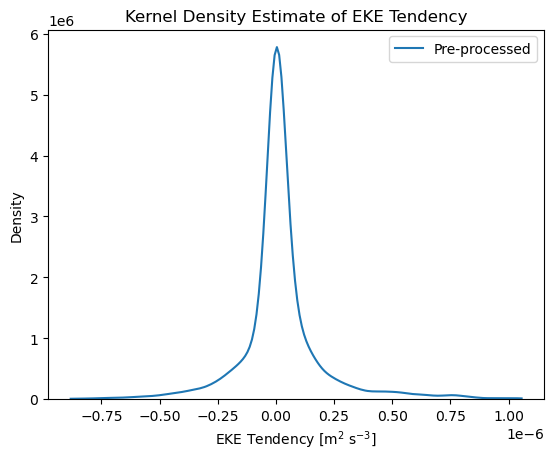

In [7]:
sns.kdeplot(df['eke_tendency'], label='Pre-processed', cut=0)

plt.title('Kernel Density Estimate of EKE Tendency')
plt.xlabel('EKE Tendency [m$^2$ s$^{-3}$]')
plt.ylabel('Density')
plt.legend()

Now take the transform following Partee et al., (2022)

In [79]:
x = ds.eke_tendency
# Compute log terms only on valid subsets to avoid warnings (xr.where does not short-circuit)
neg_term = -np.log(np.abs(x.where(x < 0))) - 19.0
pos_term =  np.log(x.where(x > 0)) + 19.0

out = xr.where(
    x < 0,
    neg_term,
    xr.where(x > 0, pos_term, 0.0),
)

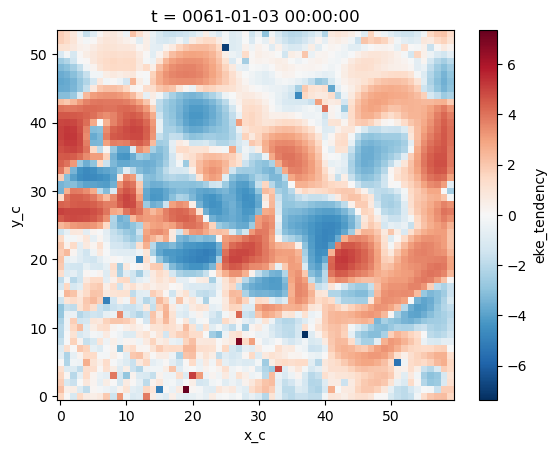

In [86]:
out.plot()

In [80]:
# Invert the Partee et al. (2022)-style transform used above
# NOTE: `out` alone does not uniquely determine the original sign near zero,
# so we use the sign of the original `ds.eke_tendency` to choose the branch.
x = ds.eke_tendency
y = out

sign = xr.where(np.isclose(x, 0.0), 0.0, np.sign(x))

x_recovered = xr.where(
    sign < 0,
    -np.exp(-(y + 19.0)),
    xr.where(
        sign > 0,
        np.exp(y - 19.0),
        0.0,
    ),
)

abs_err = np.abs(x_recovered - x)
print("max abs err:", float(abs_err.max(skipna=True)))
x_recovered

max abs err: 9.959547279784099e-09


<xarray.DataArray 'eke_tendency' (y_c: 54, x_c: 60)> Size: 26kB
array([[ 2.60118881e-08,  0.00000000e+00,  0.00000000e+00, ...,
         5.04707265e-08,  5.39293914e-08,  2.55788211e-08],
       [ 5.19557715e-08,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  3.52189428e-08,  3.44915300e-08],
       [ 3.40571542e-08, -1.87284303e-08, -2.85072604e-08, ...,
        -8.26067668e-08, -1.68009995e-08,  1.82085527e-08],
       ...,
       [ 1.70824733e-08,  1.63685335e-08,  1.23553562e-08, ...,
         0.00000000e+00,  1.07182870e-08,  0.00000000e+00],
       [ 3.16733519e-08,  2.40863392e-08,  1.42524253e-08, ...,
         2.33350838e-08,  3.10485489e-08,  1.66832495e-08],
       [ 3.49338895e-08,  2.38412480e-08,  1.26230478e-08, ...,
         4.12706546e-08,  4.58341101e-08,  2.14386706e-08]],
      shape=(54, 60))
Coordinates:
    t        object 8B 0061-01-03 00:00:00
    gphit    (y_c, x_c) float64 26kB -47.42 -47.42 -47.42 ... -37.69 -37.69
    glamt    (y_c, x_c) float64 26kB 2.625 2.875 3.125 ... 16.88 17.12 17.38
Dimensions without coordinates: y_c, x_c

In [87]:
sign

<xarray.DataArray 'eke_tendency' (y_c: 54, x_c: 60)> Size: 26kB
array([[ 1.,  0.,  0., ...,  1.,  1.,  1.],
       [ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 1., -1., -1., ..., -1., -1.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  0.,  1.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]], shape=(54, 60))
Coordinates:
    t        object 8B 0061-01-03 00:00:00
    gphit    (y_c, x_c) float64 26kB -47.42 -47.42 -47.42 ... -37.69 -37.69
    glamt    (y_c, x_c) float64 26kB 2.625 2.875 3.125 ... 16.88 17.12 17.38
Dimensions without coordinates: y_c, x_c

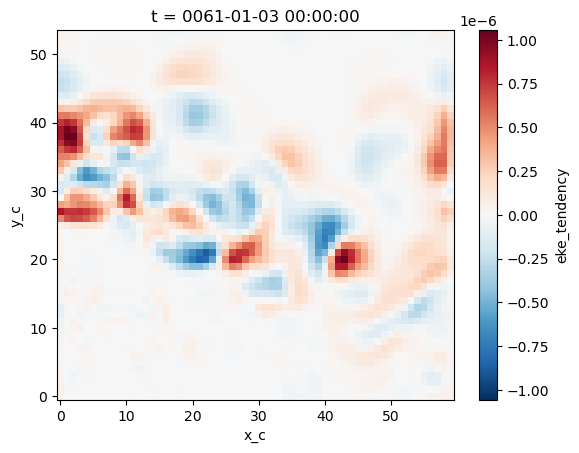

In [84]:
x_recovered.plot()

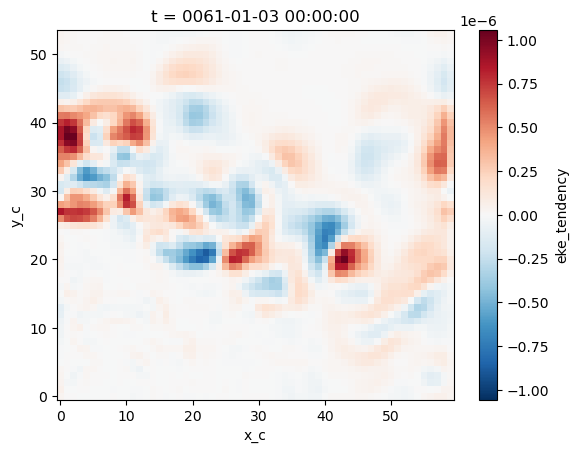

In [85]:
ds.eke_tendency.plot()

### Important: the transform is not uniquely invertible from `out` alone
Your piecewise transform maps *both* positive and negative values onto the full real line. That means for a given transformed value `y`, there is generally both a positive and a negative original value that would produce it. So **online**, if the CNN only predicts `out`, you cannot uniquely recover `eke_tendency` unless you also predict (or otherwise know) the sign/branch.

Two practical options:
1. **Predict an extra target** that encodes the sign/branch (e.g. `sign(eke_tendency)` or a 3-class label: negative / zero / positive).
2. **Use a bijective (invertible) transform** that already encodes sign in the transformed value (recommended), e.g. `asinh` or a signed `log1p` transform.

#### asinh transform

In [138]:
s = 1e-6  # scale (see below)
x = ds.eke_tendency
y_sin = np.arcsinh(x / s)
x_rec = s * np.sinh(y_sin)

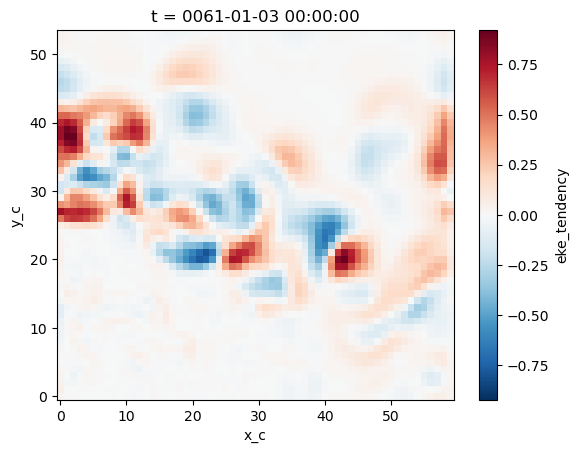

In [139]:
y_sin.plot()

In [140]:
dfy = y.to_dataframe()

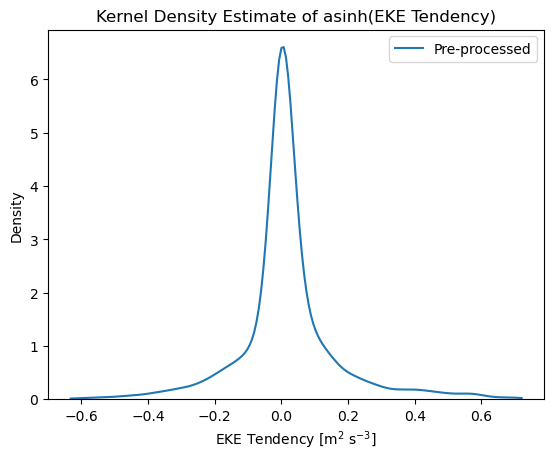

In [141]:
sns.kdeplot(dfy['eke_tendency'], label='Pre-processed', cut=0)

plt.title('Kernel Density Estimate of asinh(EKE Tendency)')
plt.xlabel('EKE Tendency [m$^2$ s$^{-3}$]')
plt.ylabel('Density')
plt.legend()

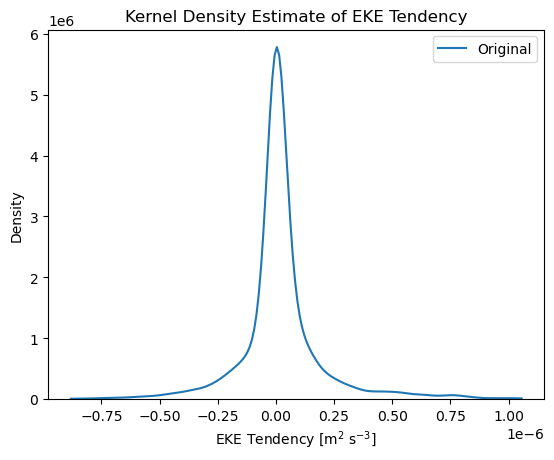

In [142]:
dfx = x.to_dataframe()
sns.kdeplot(dfx['eke_tendency'], label='Original', cut=0)
plt.title('Kernel Density Estimate of EKE Tendency')
plt.xlabel('EKE Tendency [m$^2$ s$^{-3}$]')
plt.ylabel('Density')
plt.legend()

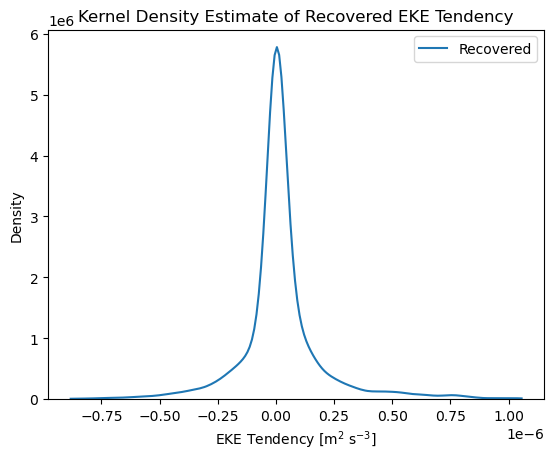

In [108]:
dfx_rec = x_rec.to_dataframe()
sns.kdeplot(dfx_rec['eke_tendency'], label='Recovered', cut=0)
plt.title('Kernel Density Estimate of Recovered EKE Tendency')
plt.xlabel('EKE Tendency [m$^2$ s$^{-3}$]')
plt.ylabel('Density')
plt.legend()

#### log1p transform

In [120]:
s = 1e-6
y_log = np.sign(x) * np.log1p(np.abs(x) / s)
x_rec = np.sign(y_log) * s * np.expm1(np.abs(y_log))

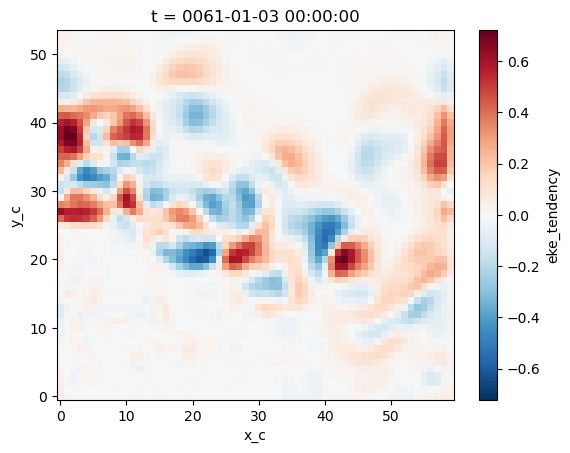

In [121]:
y_log.plot()

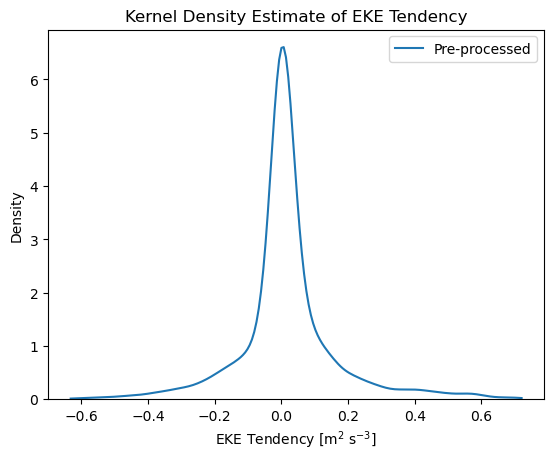

In [117]:
dfy = y.to_dataframe()
sns.kdeplot(dfy['eke_tendency'], label='Pre-processed', cut=0)
plt.title('Kernel Density Estimate of EKE Tendency')
plt.xlabel('EKE Tendency [m$^2$ s$^{-3}$]')
plt.ylabel('Density')
plt.legend()

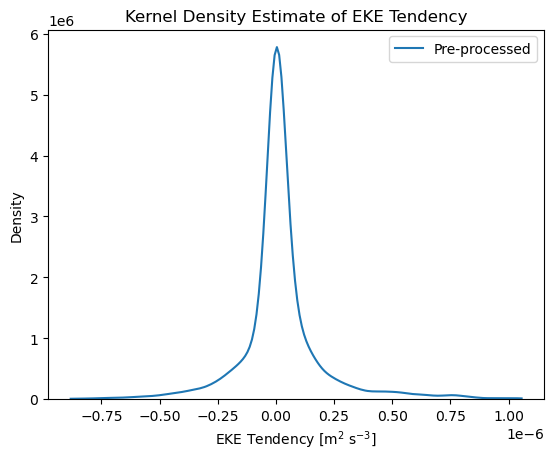

In [119]:
dfx_rec = x_rec.to_dataframe()
sns.kdeplot(dfx_rec['eke_tendency'], label='Pre-processed', cut=0)
plt.title('Kernel Density Estimate of EKE Tendency')
plt.xlabel('EKE Tendency [m$^2$ s$^{-3}$]')
plt.ylabel('Density')
plt.legend()

#### Difference between transformed data using each

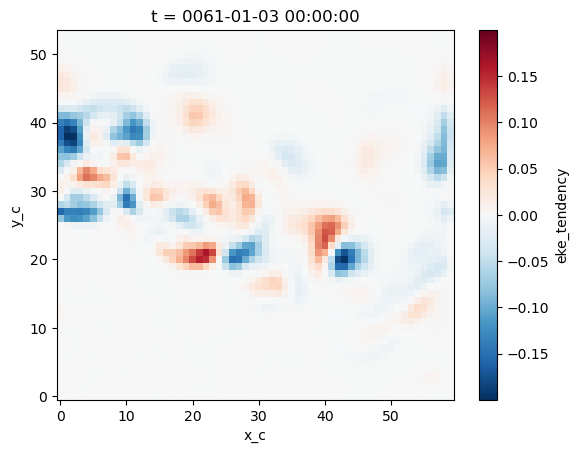

In [124]:
(y_log - y_sin).plot()

## Vorticity

In [125]:
directory = "/gws/nopw/j04/ai4pex/twilder/NEMO_data/DINO/EXP16/features/SO_JET/coarsened_data/"
filename = "MINT_1d_0061-0072_vor_cg_SO_JET.nc"
ds = xr.open_dataset(directory + filename)
ds = ds.isel(t=0)
ds

<xarray.Dataset> Size: 78kB
Dimensions:  (y_c: 54, x_c: 60)
Coordinates:
    t        int64 8B 0
    gphit    (y_c, x_c) float64 26kB ...
    glamt    (y_c, x_c) float64 26kB ...
Dimensions without coordinates: y_c, x_c
Data variables:
    vor      (y_c, x_c) float64 26kB ...
Attributes:
    name:         NEMO dataset
    description:  Relative vorticity from coarse_grained                   ge...

In [129]:
s = 1e-4  # scale (see below)
x = ds.vor
y_sin = np.arcsinh(x / s)
x_rec = s * np.sinh(y_sin)

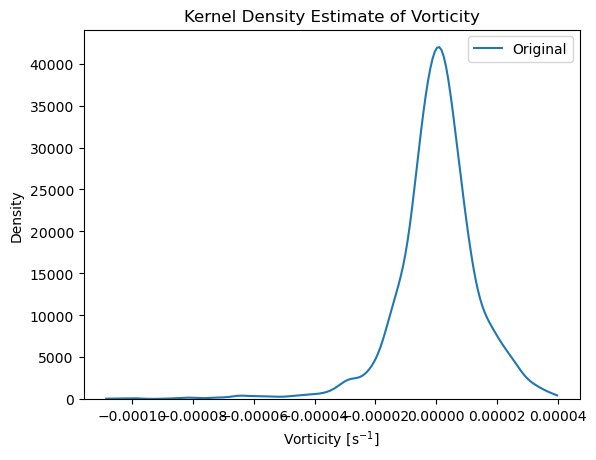

In [130]:
dfx = x.to_dataframe()
sns.kdeplot(dfx['vor'], label='Original', cut=0)
plt.title('Kernel Density Estimate of Vorticity')
plt.xlabel('Vorticity [s$^{-1}$]')
plt.ylabel('Density')
plt.legend()

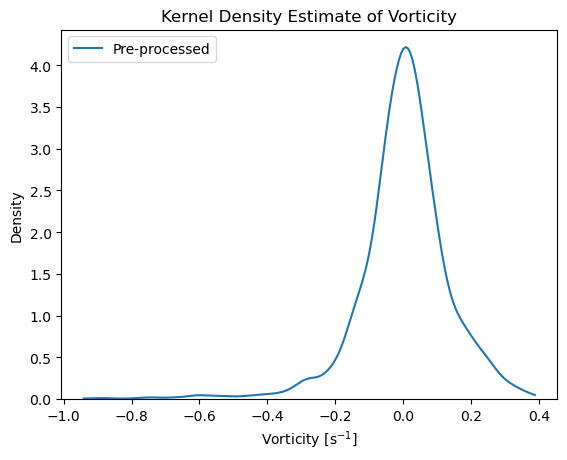

In [131]:
dfy = y_sin.to_dataframe()
sns.kdeplot(dfy['vor'], label='Pre-processed', cut=0)
plt.title('Kernel Density Estimate of Vorticity')
plt.xlabel('Vorticity [s$^{-1}$]')
plt.ylabel('Density')
plt.legend()